# Dog Breed Classification

Group members:
- Shahzeb Imtiaz
- Muhammad Shaheryar
- Waleed bin inq Satti
- Abdul hannan bin saeed
- Astri emelina Hernandez lanza
- Mauricio antonio Rodriguez moscoso

### Loading labels csv data and defining folder paths

In [38]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.1 MB/s eta 0:00:0000:0100:01


In [3]:
import os
from PIL import Image
import pandas as pd
import numpy as np

In [1]:
folder_path = "../data/dog-breed-identification/train/"

In [4]:
file_names = os.listdir(folder_path)

In [5]:
data_label = pd.read_csv("../data/dog-breed-identification/labels.csv")

In [6]:
df_label = pd.DataFrame(data_label)

In [7]:
df_label['filepath'] = folder_path + df_label['id'] + '.jpg'  
df_label.head() 

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../data/dog-breed-identification/train/000bec1...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../data/dog-breed-identification/train/001513d...
2,001cdf01b096e06d78e9e5112d419397,pekinese,../data/dog-breed-identification/train/001cdf0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../data/dog-breed-identification/train/00214f3...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../data/dog-breed-identification/train/0021f9c...


## Using the pretrained KNN model from MNIST notebook

In [8]:
def flatten_image(img_path):
    target_size = (28, 28)
    img = Image.open(img_path)  
    resized_img = img.resize(target_size)
    img_array = np.array(resized_img)
    flattened_img = img_array.flatten()
    return flattened_img


List of flatten pictures

In [9]:
resized_imgs = []
for filename in df_label['filepath']:
    resized_img = flatten_image(filename)
    resized_imgs.append(resized_img)
resized_images_array = np.array(resized_imgs)

Defining the features

In [10]:
X = resized_images_array
y = df_label['breed']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Label encoding

In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Pipeline

In [14]:
import joblib

In [15]:
knn_pipe = joblib.load("../pipeline/base_model.joblib")

In [16]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=100)),
                ('knn_classifier', KNeighborsClassifier())])

In [17]:
y_pred = knn_pipe.predict(X_test)

In [18]:
y_pred

array([ 9, 46, 74, ..., 30, 14, 50])

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.03178484107579462

As you see it's very low accuracy with the baseline model

## Dog Breed Classifcation Using Transfer Learning

In [21]:
df_label['breed'].nunique()

120

Graphical represtation to see the distrubution of the counts of each

/var/folders/lv/wyg6z79s3zq9v2mg63nwkrkm0000gn/T/ipykernel_39381/2768194702.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='breed', data=df_label, order=df_label['breed'].value_counts().index,palette="YlGnBu_r")


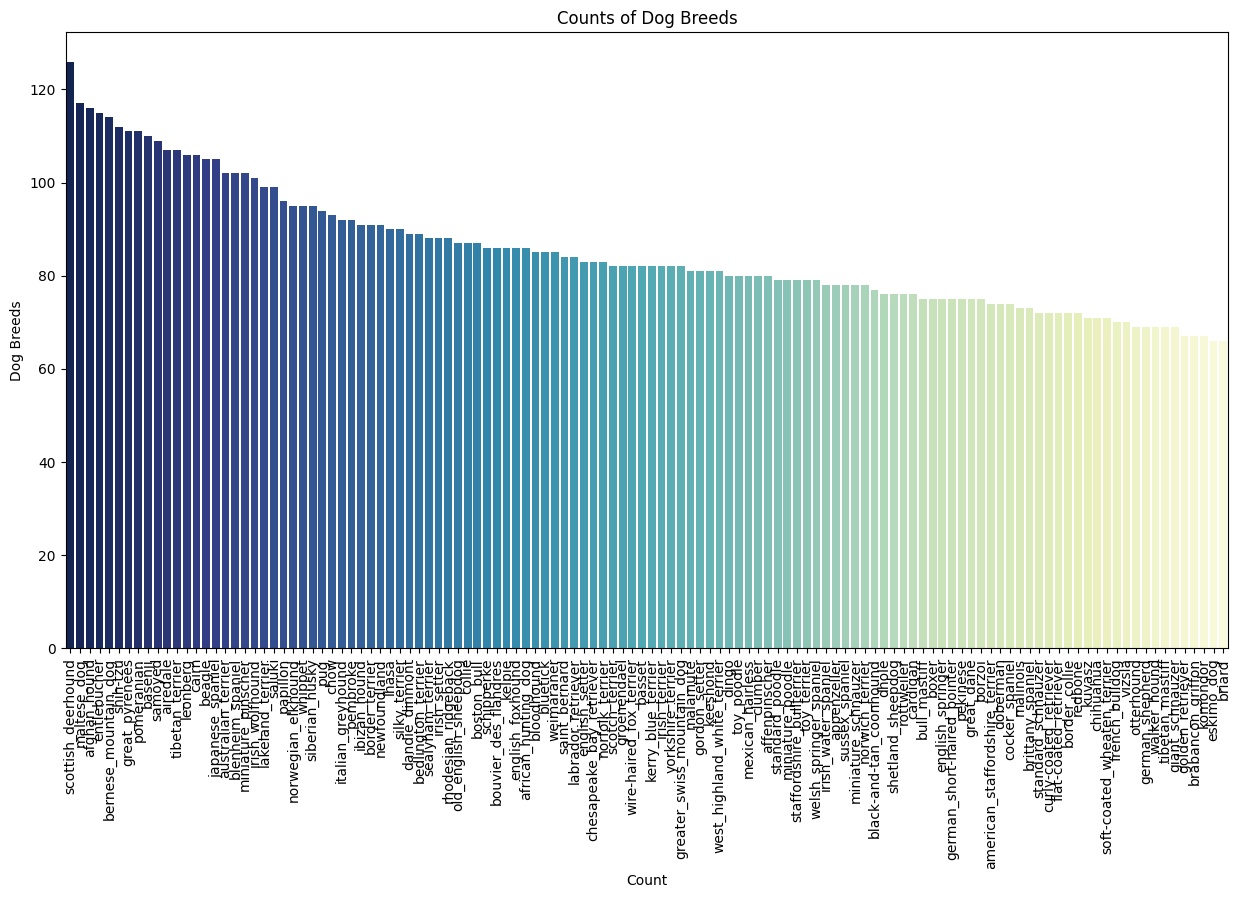

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.countplot(x='breed', data=df_label, order=df_label['breed'].value_counts().index,palette="YlGnBu_r")
plt.title('Counts of Dog Breeds')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.ylabel('Dog Breeds')
plt.show()

In [39]:
import cv2
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [41]:
resized_images = []
for filename in df_label['filepath']:
    ## Doing th same step as in the preprocessing step in baseline model
    resized_img = read_and_resize_image_rgb(filename)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [42]:
from tensorflow.python.keras.utils.np_utils import to_categorical

## encoding the target variable

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df_label['breed'])
new_labels = to_categorical(label_encoded)

In [43]:
X = resized_images_array
y = new_labels

In [44]:
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.models import Model

In [45]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [46]:
import tensorflow
from tensorflow.keras.applications import ResNet50

In [47]:
resnet_preprocessor = tensorflow.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

320/320 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step
Feature maps shape: (10222, 2048)


In [52]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

# Create the Sequential model
model = Sequential()
# Add Dropout layer with the correct input shape
model.add(Dropout(0.5, input_shape=(resnet_features.shape[1],)))
# Add Dense layer
model.add(Dense(120, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Users/shahzeb/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
from tensorflow.python.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [54]:
history = model.fit(resnet_features, y,
                    batch_size=128,
                    epochs=100,
                    validation_split=0.15,
                    callbacks=[early_stopping])

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1209 - loss: 4.4914 - val_accuracy: 0.6780 - val_loss: 1.3034
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5952 - loss: 1.4569 - val_accuracy: 0.7438 - val_loss: 0.9235
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7294 - loss: 0.9368 - val_accuracy: 0.7673 - val_loss: 0.8258
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7803 - loss: 0.7351 - val_accuracy: 0.7666 - val_loss: 0.7751
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.5953 - val_accuracy: 0.7744 - val_loss: 0.7313
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8471 - loss: 0.5082 - val_accuracy: 0.7849 - val_loss: 0.7187
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8645 - loss: 0.4394 - val_accuracy: 0.7927 - val_loss: 0.6999
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8864 - loss: 0.3903 - val_accuracy: 0.7868 - v